<h3>Model - Logistic Regression</h3>

In [301]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score,precision_score,f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

import cleaning
import models

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2
# pd.set_option('display.max_columns', 999)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h4>Model1</h4>

In order to fit a logistic regression, we need to transform categorical data series to dummy data series (1 or 0). 
Here we will fit the model using the past payments data in amount rather than % so we drop them.

We then scale the data using the MinMaxScaler before fitting the model.

In order to find the best hyperparameter we use grid search to try to improve the model result (we are using AUC score here).

In [59]:
df = cleaning.clean_raw()
df.drop(columns=['pay_0','pay_2', 'pay_3', 'pay_4','pay_5','pay_6'], inplace=True)
df.drop(columns=['pay%_1','pay%_2', 'pay%_3', 'pay%_4','pay%_5'], inplace=True)

arr = []
for i in range(1,7):
    arr.append(f'arrears_{i}')

x_feats = ['sex', 'education', 'marriage'] + arr

In [60]:
# get dummy variables for catagorical data and set X, y
X = pd.get_dummies(df, columns=x_feats, drop_first=True)
X.drop(columns=['default'], inplace=True)
y = df['default']

In [179]:
# train test split, test being 30% of dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

# scale your X
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.transform(X_test)

<h5>Model Fitting and Results</h5>

Accuracy is :0.8173

AUC is :0.755


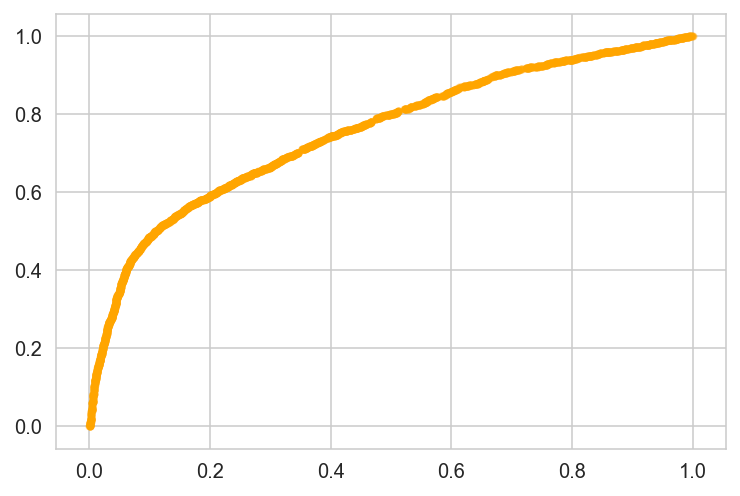

In [313]:
# call function to run logistic refression model, train test split is included in function
models.log_reg(X_train_scale,X_test_scale,y_train, y_test,0.1,'l1');

In [302]:
# using Grid search to get the best hyperparameter for the log reg model
best_c, best_pen, best_params = models.grid_search(X_train_scale, y_train, score = 'roc_auc', cv=3)

(206.913808111479, 'l1')

In [311]:
# best_c, best_pen

Accuracy is :0.8198

AUC is :0.761


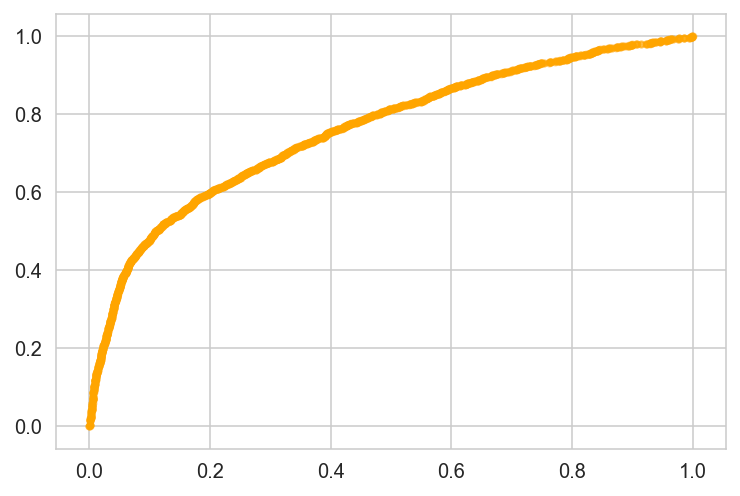

In [317]:
# see the AUC based on test data with best params found before
acc, roc_auc, ftr, tpr, conf_matrix, log_reg =  models.log_reg(
    X_train_scale,X_test_scale,y_train, y_test,best_c, best_pen);

The best hyperparameter to produce the highest AUC on the training data is C = 206, penality = 'l1'. 
This model gives a 82% accuracy on the test dataset, and a AUC on the roc curve of 0.761.

<h5>Study the model coef</h5>

Here we look to extract the coefficients from the best logistic regression model and try to interpret it.

In [319]:
# assign the coef from the best model above
coef = logreg.coef_
model_result = pd.DataFrame(coef.reshape(-1, len(coef)), index=X_train.columns, columns=['coef_value'])

In [320]:
# add a column that only looks at the magnitude/affect of the coef not the direction
model_result['coef_abs'] = model_result['coef_value'].apply(lambda x: np.abs(x))

In [321]:
model_result.sort_values('coef_abs', ascending=False).head(10)

,coef_value,coef_abs
pay_amt2,-22.547595,22.547595
bill_amt3,6.566783,6.566783
pay_amt1,-5.236798,5.236798
arrears_3_1,-3.028354,3.028354
bill_amt1,-2.141352,2.141352
arrears_1_2,2.037263,2.037263
arrears_1_3,1.978431,1.978431
limit_bal,-1.876363,1.876363
bill_amt2,1.794293,1.794293
bill_amt6,-1.349506,1.349506


looking at the above result for the variables with the highest coef, its not the arrears with status 2, 3, but rather payments data, in particular recent payments data. Ituitively speaking, it would make more sense to use recent payments as a % of the outstanding balance rather than amounts. Hence we will do this for the next model to see if we can improve the model.

<h4>Model 2 - Using Payments as a % of balance rather than amount </h4>

We need to do some extra data cleaning as the payments as  % of balance data contains some NaN(where balance was 0), and some inf values.

We then proceed to carry out model fitting and grid search to find best hyperparameter.

In [268]:
df2 = cleaning.clean_raw()

In [269]:

df2.drop(columns=['pay_0','pay_2', 'pay_3', 'pay_4','pay_5','pay_6'], inplace=True)
df2.drop(columns=['pay_amt1','pay_amt2', 'pay_amt3', 'pay_amt4','pay_amt5'], inplace=True)

arr = []
for i in range(1,7):
    arr.append(f'arrears_{i}')

x_feats = ['sex', 'education', 'marriage'] + arr

In [270]:
df2.replace([np.inf, -np.inf], np.nan,inplace=True)

# around 3k to 4k of rows with NaN pay%_ missing as balance was zero for these
df2.dropna(axis=0, inplace=True)

In [271]:
X2 = pd.get_dummies(df2, columns=x_feats, drop_first=True)
X2.drop(columns=['default'], inplace=True)
y2 = df2['default']

In [274]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

scaler = MinMaxScaler()

# scale your X
X2_train_scale = scaler.fit_transform(X2_train)
X2_test_scale = scaler.transform(X2_test)

Accuracy is :0.8284

AUC is :0.785


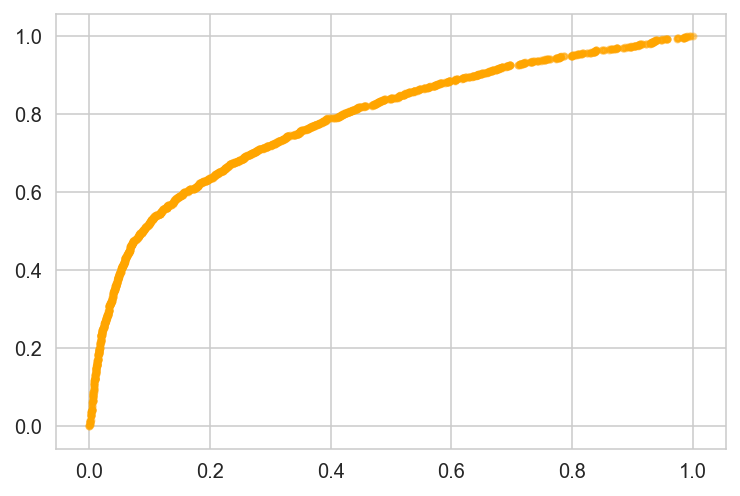

In [329]:
# taking the best c from last model as a base
models.log_reg(X2_train_scale,X2_test_scale,y2_train, y2_test, 0.2,'l1');

In [289]:
# call function to get the best params for the log reg model
best_c2, best_pen2, best_params2 = models.grid_search(X2_train_scale, y2_train, score = 'roc_auc', cv=3)

Accuracy is :0.8289

AUC is :0.783


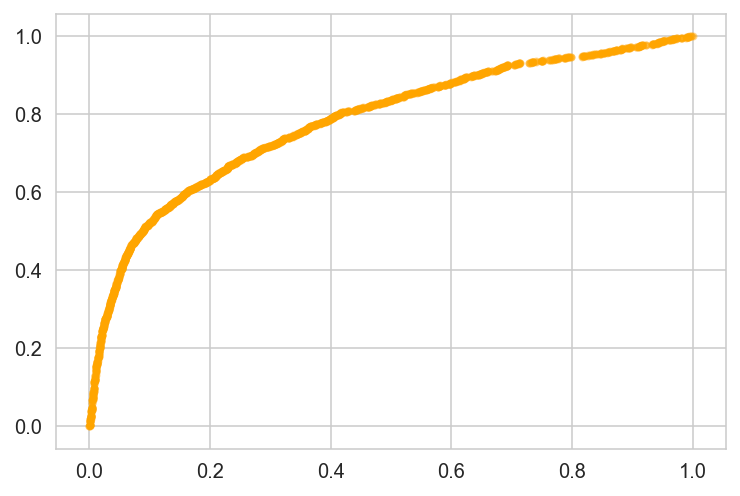

In [290]:
# find the AUC using test dataset
models.log_reg(X2_train_scale,X2_test_scale,y2_train, y2_test,best_c2,best_pen2);

Using grid search have not produced a superier model. However we have managed to improve on model 1. 

Our best model has a 83% accuracy and a AUC of 0.785.

<h4>Trying WOE & IV method</h4>

In [ ]:
df3 = cleaning.clean_raw()

df3.drop(columns=['pay_0','pay_2', 'pay_3', 'pay_4','pay_5','pay_6'], inplace=True)
df3.drop(columns=['pay_amt1','pay_amt2', 'pay_amt3', 'pay_amt4','pay_amt5'], inplace=True)

x_cont = ['limit_bal','bill_amt1','bill_amt2','bill_amt3','pay%_1','pay%_2','pay%_3']
x_feats

In [300]:
x_cont = ['limit_bal','bill_amt1','bill_amt2','bill_amt3','pay%_1','pay%_2','pay%_3']
x_feats

['sex',
 'education',
 'marriage',
 'arrears_1',
 'arrears_2',
 'arrears_3',
 'arrears_4',
 'arrears_5',
 'arrears_6']

In [239]:
for col in ['limit_bal','bill_amt1','bill_amt2','bill_amt3','pay%_1','pay%_2','pay%_3']:
    if col not in [x_feats]:
    # scale it
        X[col] = (X[col] - min(X[col]))/ (max(X[col]) - min(X[col])) 
    
#     # create bins for age
#     df['age_bucket'] = pd.cut(df.age, bins=[0, 25, 30, 35, 40, 50, 80])

limit_bal


In [299]:
df2.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'bill_amt1',
       'bill_amt2', 'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6',
       'pay_amt6', 'default', 'pay%_1', 'pay%_2', 'pay%_3', 'pay%_4', 'pay%_5',
       'arrears_1', 'arrears_2', 'arrears_3', 'arrears_4', 'arrears_5',
       'arrears_6'],
      dtype='object')